In [1]:
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
import pickle
from matplotlib.pyplot import cm
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
import matplotlib.pyplot as plt

/tmp/ipykernel_106123/1359497767.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_Kp_v_Vsys_LogL_SNR" + str(date_time) + ".pdf", fmt="pdf")


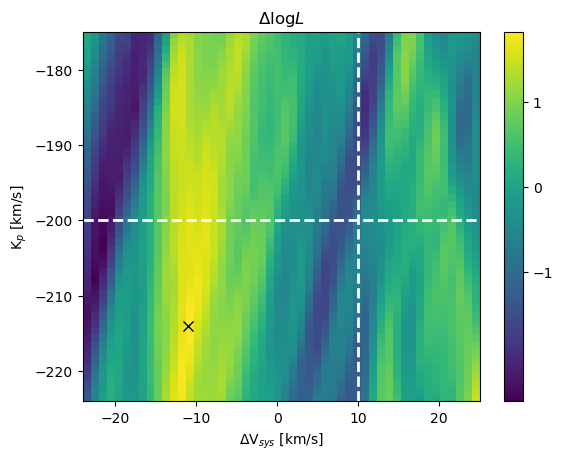

/tmp/ipykernel_106123/1359497767.py:85: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_Kp_v_Vsys_LogL_SNR" + str(date_time) + ".pdf", fmt="pdf")


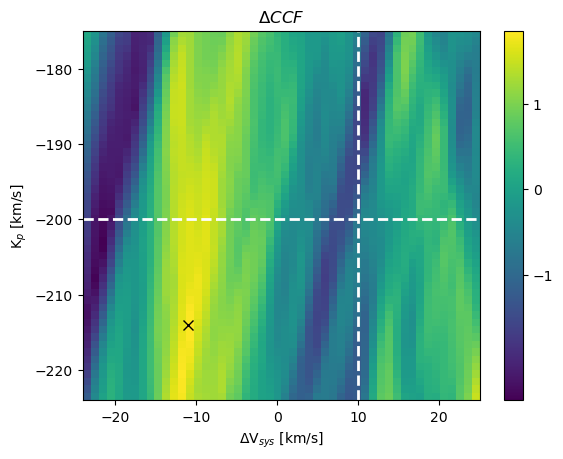

/tmp/ipykernel_106123/1359497767.py:98: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_TOTAL_logL_SLICE.pdf", fmt="pdf")


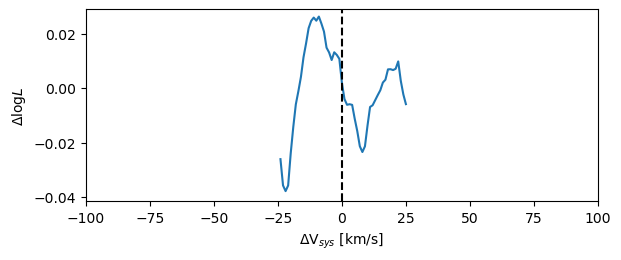

In [5]:
output_path = "./CC_output/WASP-76b-injection-Fe-3/"
name = "BEST_FIT"

# logL, CCF, V_sys_arr, K_p_arr = pickle.load(
#     open(output_path + "cross_correlation_results.pic", "rb")
# )

K_p = -200
N_K_p = 50
d_K_p = 1
K_p_arr = (
    np.arange(N_K_p) - (N_K_p - 1) // 2
) * d_K_p + K_p  # making K_p_arr (centered on published or predicted K_p)
# K_p_arr = [92.06 , ..., 191.06, 192.06, 193.06, ..., 291.06]

V_sys = 0
N_V_sys = 50
d_V_sys = 1
V_sys_arr = (
    np.arange(N_V_sys) - (N_V_sys - 1) // 2
) * d_V_sys + V_sys  # making V_sys_arr (centered on published or predicted V_sys (here 0 because we already added V_sys in V_bary))


logL, CCF = pickle.load(open(output_path + "cross_correlation_results.pic", "rb"))

K_p = -200
V_sys = 10  # True value

# logL
CCFarr1 = logL[::-1, :]
CCFarr1 = CCFarr1 - np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev = np.std(CCFarr1)
maxx = (CCFarr1 / stdev).max()
loc = np.where(CCFarr1 / stdev == maxx)


fig, ax = subplots()
cax = ax.imshow(
    (CCFarr1) / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    interpolation="none",
)

cbar = colorbar(cax, ticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[::-1][loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta $log$L$")

now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path + name + "_Kp_v_Vsys_LogL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# CCF
CCFarr1 = CCF[::-1, :]
CCFarr1 = CCFarr1 - np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev = np.std(CCFarr1)
maxx = (CCFarr1 / stdev).max()
loc = np.where(CCFarr1 / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    (CCFarr1) / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    interpolation="none",
)
cbar = colorbar(cax, ticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[::-1][loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta CCF$")
savefig(output_path + name + "_Kp_v_Vsys_LogL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# slice at Kp
slicee = CCFarr1[len(CCFarr1) // 2]
plot(V_sys_arr, slicee)
axis([-100, 100, 1.1 * slicee.min(), 1.1 * slicee.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("$\Delta$log$L$")
axvline(x=0, ls="--", color="black")
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path + name + "_TOTAL_logL_SLICE.pdf", fmt="pdf")
show()
close()